
## Classify dogs vs. cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

For today's models/algos, this is pretty much like a toy problem. I used this to try the EfficientNet.


### Data

The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id. For each image in the test set, you should predict a probability that the image is a dog (1 = dog, 0 = cat).


### Evaluation

Submissions are scored on the log loss.

If model is very confident but wrong, it will get penalized a lot. So maybe better not be extremely confident with preds (clip the probabilities?)

### Outline

Create Datasets and DataLoaders. Use pretrained EfficientNet-b7 model to extract features (vector of length 2560, kind of embedding from the image) from the penultimate layer of the pretrained EffNet model.

Train a simple classifier using these embeddings as input.

Perhaps finetune the pretrained model a bit (let's see, might be somewhat slow).

### Setting things up

First, install albumentations for (simple) data aug.



In [1]:
!pip install -U -q albumentations efficientnet_pytorch

     |████████████████████████████████| 102 kB 4.6 MB/s 
     |████████████████████████████████| 47.7 MB 49.2 MB/s 


In [2]:
# There is an issue with opencv-python-headless        4.5.5.62.
# Uninstall that, install 4.5.2.52
!pip list | grep opencv

opencv-contrib-python         4.1.2.30
opencv-python                 4.1.2.30
opencv-python-headless        4.5.5.62


In [3]:
# Use working version of opencv-python-headless
!pip uninstall -q -y opencv-python-headless==4.5.5.62
!pip install -q opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.5 MB/s 


In [4]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Add Kaggle creds
!mkdir ~/.kaggle
!cp drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Imports

import numpy as np
import pandas as pd

import os
import re
import random
from tqdm import tqdm

from PIL import Image
import IPython.display

from pathlib import Path

from collections import defaultdict, Counter

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from efficientnet_pytorch import EfficientNet

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt


### Download the data

And have a quick look at it.

In [7]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 16.4MB/s]
 96% 261M/271M [00:02<00:00, 85.5MB/s]
100% 271M/271M [00:03<00:00, 92.3MB/s]
 98% 534M/544M [00:07<00:00, 89.6MB/s]
100% 544M/544M [00:07<00:00, 78.4MB/s]


In [9]:
!ls

drive  sample_data  sample_submission.csv  test.zip  train.zip


In [10]:
!head -n 5 sample_submission.csv

id,label
1,0.5
2,0.5
3,0.5
4,0.5


In [12]:
!tail -n 5 sample_submission.csv

12496,0.5
12497,0.5
12498,0.5
12499,0.5
12500,0.5


So the submission format has the following cols:
- test set id [1...12500]
- predicted probability of that image being of a dog

In [8]:
!unzip -q train.zip
!unzip -q test.zip

In [9]:
PATH_TRAIN = Path("train")
PATH_TEST = Path("test")

In [10]:
# number of files in train and test
len(os.listdir(PATH_TRAIN)), len(os.listdir(PATH_TEST))

(25000, 12500)

In [11]:
!ls train | head -n 4
# filename has the ground truth

cat.0.jpg
cat.10000.jpg
cat.10001.jpg
cat.10002.jpg


In [12]:
!ls test | head -n 4

10000.jpg
10001.jpg
10002.jpg
10003.jpg


In [13]:
def get_random_img_from_folder(path: "Path") -> str:
  IMG_EXTENSIONS = ("jpg", "jpeg", "png")
  imgs_in_folder = [path / fn for fn in os.listdir(path) if fn.split(".")[-1] in IMG_EXTENSIONS]
  return str(random.choice(imgs_in_folder))


train/dog.4208.jpg


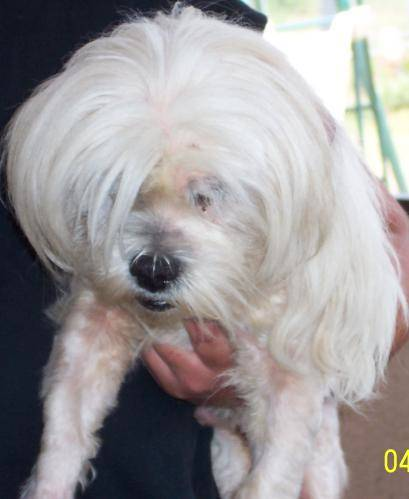

In [14]:
# Show a random train image
img_fp = get_random_img_from_folder(PATH_TRAIN)
print(img_fp)
IPython.display.Image(img_fp)

### Check class balance

In [19]:
# Class balance in train
class_counts = Counter(fn.split(".")[0] for fn in os.listdir(PATH_TRAIN))
class_counts  # perfectly balanced

Counter({'cat': 12500, 'dog': 12500})

### Check resolutions

In [19]:
# Resolutions
# !file train/cat.774.jpg  

In [20]:
def get_img_size(img_fn) -> tuple:
  im = Image.open(img_fn)
  return im.size  # width, height

In [21]:
train_sizes = [get_img_size(fp) for fp in PATH_TRAIN.glob("*.jpg")]
train_sizes.sort(key=lambda x: x[0])

test_sizes = [get_img_size(fp) for fp in PATH_TEST.glob("*.jpg")]
test_sizes.sort(key=lambda x: x[0])

In [22]:
# Get binned resolution counts
train_sizes_binned = defaultdict(int)
test_sizes_binned = defaultdict(int)

for w, h in train_sizes:
  train_sizes_binned[(100 * (w // 100), 100 * (h // 100))] += 1

for w, h in test_sizes:
  test_sizes_binned[(100 * (w // 100), 100 * (h // 100))] += 1


In [46]:
#train_sizes_binned

In [47]:
#test_sizes_binned

In [36]:
# Plot the image resolutions

bin_labels = list(train_sizes_binned.keys())
train_bin_size_counts = list(train_sizes_binned.values())
test_bin_size_counts = []

for bin_label in bin_labels:
  test_bin_size_counts.append(test_sizes_binned[bin_label])


bin_labels_str = [str(label) for label in bin_labels]

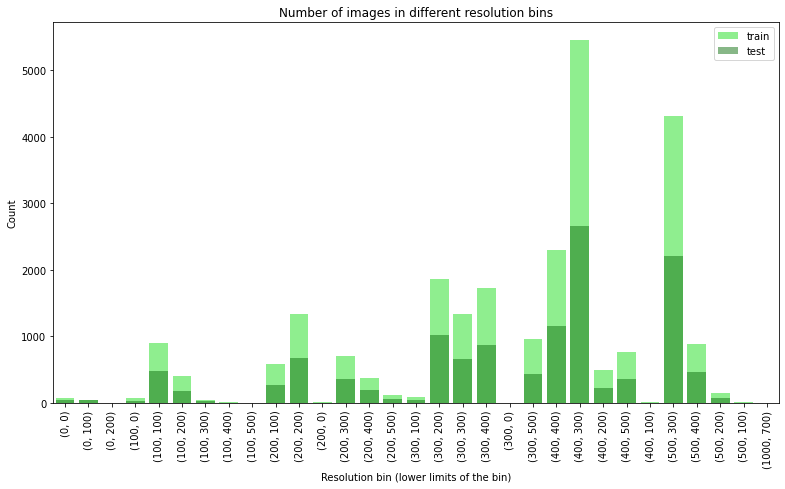

In [44]:
import seaborn as sns

#creating subplots
ax = plt.subplots(figsize=(13,7))
 
#plotting columns
ax = sns.barplot(x=bin_labels_str, y=train_bin_size_counts, color = 'lime', label="train", alpha=0.5)
ax = sns.barplot(x=bin_labels_str, y=test_bin_size_counts, color = 'green', label="test", alpha=0.5)
plt.legend()
plt.title("Number of images in different resolution bins");
plt.xlabel("Resolution bin (lower limits of the bin)");
plt.ylabel("Count");

plt.xticks(rotation=90)
 
plt.show()

Resolution distribution looks quite similar in train and test.

Both sets have a range of different resolutions. Somewhat similarly distributed.

### Config

In [15]:
# CONFIG
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, 
# you can speed up the host to device transfer by enabling pin_memory.
# This lets the DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.
PIN_MEMORY = True
BATCH_SZ = 64

# On colab: "our suggested max number of worker in current system is 2"
NUM_WORKERS = 2 

LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_FN = Path(r"model.pth.tar")

NUM_EPOCHS = 1
WEIGHT_DECAY = 1e-4
LR = 1e-4


Device: cuda


### Data (image) augmentation

In [16]:
# Image transforms
# Could add some more for regularization

transforms_basic = A.Compose(
  [
   A.Resize(height=448, width=448),
   # Normalization is applied by the formula: `img = (img - mean * max_pixel_value) / (std * max_pixel_value)`
   # given mean and std values are from ImageNet (should be applied by default, but I am just verbose here)
   A.Normalize(mean=(0.485, 0.456, 0.406), 
               std=(0.229, 0.224, 0.225), 
               max_pixel_value=255.0),
   # Convert numpy -> pytorch tensor (ToTensor() is deprecated)
   ToTensorV2() 
  ]
)

### Define the dataset

In [17]:
# DATASET
class DogCatDataset(Dataset):
  def __init__(self, folder: "Path", tfms=None):
    self.folder = folder
    # transforms
    self.tfms = tfms
    # folder contains only image files
    self.imgs = [self.folder / fn for fn in os.listdir(folder)]
    # sort by id
    self.imgs.sort(key=lambda x: int(re.findall(r"\d+", str(x))[0]))

  def __len__(self) -> int:
    return len(self.imgs)

  def __getitem__(self, idx: int):
    """Returns img (np.array) and label (int)"""
    fp = self.imgs[idx]

    if "dog" in fp.name:
      label = 1
    elif "cat" in fp.name:
      label = 0
    else:
      label = -1  # we should not have these

    img = np.array(Image.open(fp))

    if self.tfms:
      img = self.tfms(image=img)["image"]

    return img, label


There are different EfficientNet implementations. Differences, which one to use?

In [18]:
def extract_and_save_feats(model, dataloader, output_folder: "Path", 
                           base_fn, output_size=(1, 1)):
  """Runs data (from dataloader) thru the model in evaluation mode 
  and extracts the features (before the top layer)"""
  model.eval()

  imgs = []
  labels = []

  for idx, (x, y) in enumerate(tqdm(dataloader)):
    x = x.to(DEVICE)

    with torch.no_grad():
      feats = model.extract_features(x)
      feats = F.adaptive_avg_pool2d(feats, output_size=output_size)

    imgs.append(feats.reshape(x.shape[0], -1).detach().cpu().numpy())
    labels.append(y.numpy())
  
  np.save(output_folder / f"X_{base_fn}.npy" , np.concatenate(imgs, axis=0))
  np.save(output_folder / f"y_{base_fn}.npy", np.concatenate(labels, axis=0))
  
  # set back to training mode
  model.train()

In [19]:
# Setup model, datasets, loaders
model = EfficientNet.from_pretrained('efficientnet-b7')  # One of the bigger effnets, 66M params

train_ds = DogCatDataset(folder=PATH_TRAIN, tfms=transforms_basic)
test_ds = DogCatDataset(folder=PATH_TEST, tfms=transforms_basic)

train_loader = DataLoader(train_ds,
                          shuffle=True,
                          batch_size=BATCH_SZ,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY)


test_loader = DataLoader(test_ds,
                          shuffle=False,
                          batch_size=BATCH_SZ,
                          num_workers=NUM_WORKERS)


# 
print("Using device:", DEVICE)
model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7
Using device: cuda


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        64, 16, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        16, 64, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        64, 32, kernel_siz

In [21]:
# Setup paths
# local folders for submissions and extracted features
os.makedirs("subs", exist_ok=True)
os.makedirs("extracted_feats", exist_ok=True)

# GDrive
PATH_SUBS_GDRIVE = Path('drive/MyDrive/colab/dogs_vs_cats/subs')
os.makedirs(PATH_SUBS_GDRIVE, exist_ok=True)

PATH_EXTRACTED_FEATS = Path("extracted_feats")
PATH_EXTRACTED_FEATS_GDRIVE = Path("drive/MyDrive/colab/dogs_vs_cats/")

LOAD_EXTRACTED_FROM_GDRIVE = True



### Extract features

In [22]:
EXTRACT_FEATURES = False

if EXTRACT_FEATURES:
  extract_and_save_feats(model, train_loader, 
                        output_folder=PATH_EXTRACTED_FEATS, 
                        base_fn="train")
  
  extract_and_save_feats(model, test_loader, 
                       output_folder=PATH_EXTRACTED_FEATS, 
                       base_fn="test")
  
  # Copy to GDrive
  !cp $PATH_EXTRACTED_FEATS/* PATH_EXTRACTED_FEATS_GDRIVE

else:
  print("Not extracting features...")


Not extracting features...


In [102]:
# files containing the extracted features in GDrive
#!ls drive/MyDrive/colab/dogs_vs_cats/

### Use the extracted features to train a simple classifier

In [101]:
if LOAD_EXTRACTED_FROM_GDRIVE:
  X = np.load(PATH_EXTRACTED_FEATS_GDRIVE / "X_train.npy")
  y = np.load(PATH_EXTRACTED_FEATS_GDRIVE / "y_train.npy")
  X_test = np.load(PATH_EXTRACTED_FEATS_GDRIVE / "X_test.npy")
  
  print("X, y shapes:", X.shape, y.shape)
  print("X test shape:", X_test.shape)


X, y shapes: (25000, 2560) (25000,)
X test shape: (12500, 2560)


In [36]:
X[0,:], y[0]

(array([ 0.05899539, -0.11539324,  0.06684683, ...,  0.02120467,
        -0.11684679,  0.08657771], dtype=float32), 1)

In [59]:
# PCA 2D plot for a quick look at the separability
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print(
    "Explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)


Explained variance ratio (first two components): [0.12451088 0.0556852 ]


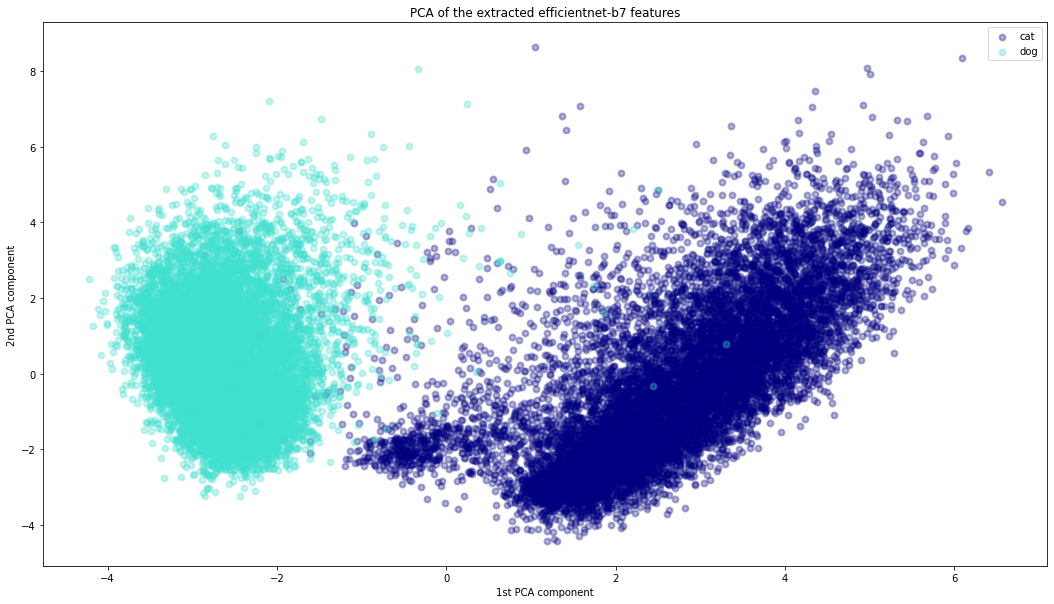

In [60]:
# Plot the PCA 2D
plt.figure(figsize=(18, 10))
colors = ["navy", "turquoise"]
class_names = ["cat", "dog"]
lw = 2

for color, i, class_name in zip(colors, [0, 1], class_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.3, lw=lw, label=class_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of the extracted efficientnet-b7 features");
plt.xlabel("1st PCA component");
plt.ylabel("2nd PCA component");

# Seems to be for the most part easy to separate these two classes

In [103]:
# Train val split
VAL_PROPORTION = .1

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=VAL_PROPORTION, 
                                                  stratify=y, 
                                                  random_state=33)


In [62]:
# Fit a simple LogisticRegression on the extracted features
clf = LogisticRegression(max_iter=3000, n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, n_jobs=-1)

In [63]:
preds_val = clf.predict_proba(X_val)[:, 1]  # probas for class Dog
preds_classes_val = clf.predict(X_val)  # predicted classes

print("Valid acc:", clf.score(X_val, y_val))

Valid acc: 0.9956


In [64]:
# Check what happens with different probability value clipping constants
CLIP_VALS = [0.00000001, 0.0000001, 0.000001, 0.000005, 0.00001, 0.00005, 
             0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02]

for clip_val in CLIP_VALS:
  print("Clip value:", clip_val)

  preds_val_clipped = np.clip(preds_val, clip_val, 1 - clip_val)
  #print("Valid acc:", clf.score(X_val, y_val))
  print("Valid log loss:", log_loss(y_val, preds_val_clipped))
  print("----------------------------------------------------")

# In validation, the model is so accurate that the best clip rate is very low / no clipping?

Clip value: 1e-08
Valid log loss: 0.01115159233761553
----------------------------------------------------
Clip value: 1e-07
Valid log loss: 0.011151596920282896
----------------------------------------------------
Clip value: 1e-06
Valid log loss: 0.011151738671516954
----------------------------------------------------
Clip value: 5e-06
Valid log loss: 0.01115287203261636
----------------------------------------------------
Clip value: 1e-05
Valid log loss: 0.011154758467292736
----------------------------------------------------
Clip value: 5e-05
Valid log loss: 0.011176114838663024
----------------------------------------------------
Clip value: 0.0001
Valid log loss: 0.01120894840043272
----------------------------------------------------
Clip value: 0.0005
Valid log loss: 0.011530063555339677
----------------------------------------------------
Clip value: 0.001
Valid log loss: 0.011973063450181457
----------------------------------------------------
Clip value: 0.005
Valid log l

In [65]:
# How much the predictios were off from the ground truth?
misses = (preds_val - y_val)
sorted_misses = np.argsort(misses)

sorted_misses

array([1793,  863, 1232, ...,  277,  843,  815])

In [66]:
# Largest miss: was very confident that this image is a dog, it wasnt
# What image is this? Would need to rework a bit to get this. Skip for now.
misses[815], y_val[815]

(0.9966421532965734, 0)

In [68]:
# Create submission with logisticregression.
# Get preds for the test set

SELECTED_CLIP_VAL = 0.005  # lets just assume this is a good value to use...
preds_test = clf.predict_proba(X_test)[:, 1]  # probas for class Dog
preds_test = np.clip(preds_test, SELECTED_CLIP_VAL, 1 - SELECTED_CLIP_VAL)  # find opt vals?

# test ids go from 1 to 12500
df = pd.DataFrame({"id": np.arange(1, 12501),
                   "label": preds_test})

df.to_csv("subs/my_submission.csv", index=False)

# Copy to GDrive
!cp subs/my_submission.csv $PATH_SUBS_GDRIVE/"my_submission.csv"

In [ ]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f subs/my_submission.csv -m "LogReg with increased max_iter on effnet-b7 feats (clip 0.01)"

100% 126k/126k [00:01<00:00, 74.8kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

The above submission gives private leaderboard score (logloss) of something like 0.356, which would have already taken us to 6th place in the competition.

We can improve a bit by using the validation data to train the logreg model.

In [ ]:
# Use val data for training
clf = LogisticRegression(max_iter=3000, n_jobs=-1)
clf.fit(X, y)  # fit on the whole train dataset (i.e incl. the 10% validation data)


SELECTED_CLIP_VAL = 0.005  # this was one of the better values based on the 
preds_test = clf.predict_proba(X_test)[:, 1]  # probas for class Dog
preds_test = np.clip(preds_test, SELECTED_CLIP_VAL, 1 - SELECTED_CLIP_VAL)  # find opt vals?

# test ids go from 1 to 12500
df = pd.DataFrame({"id": np.arange(1, 12501),
                   "label": preds_test})

os.makedirs("subs", exist_ok=True)
df.to_csv("subs/my_submission_all_tr_data.csv", index=False)

# Copy to GDrive
!cp subs/my_submission.csv $PATH_SUBS_GDRIVE/"my_submission_all_tr_data.csv"

# Submit
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f subs/my_submission_all_tr_data.csv -m "LogReg with increased max_iter on effnet-b7 feats (clip 0.005), using val data to train"


100% 139k/139k [00:01<00:00, 78.0kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

Private score: 0.03543, 6th place.

Quickly check RF and XGB classifiers to check what kind of results are they giving.

In [69]:
# Try randomforest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1)

In [70]:
pred_probas_val_rf = rf_clf.predict_proba(X_val)[:, 1]  # for dogs
pred_probas_val_rf_clipped = np.clip(pred_probas_val_rf, 0.005, 0.995)

print("RF val score:", rf_clf.score(X_val, y_val))
print("RF log loss:", log_loss(y_val, pred_probas_val_rf_clipped))


RF val score: 0.9968
RF log loss: 0.03802513013999438


In [ ]:
# try xgboost
import xgboost as xgb
from xgboost import XGBClassifier

xgb_clf = RandomForestClassifier(n_jobs=-1)
xgb_clf.fit(X_train, y_train)


pred_probas_val_xgb = xgb_clf.predict_proba(X_val)[:, 1]  # for dogs
pred_probas_val_xgb_clipped = np.clip(pred_probas_val_xgb, 0.005, 0.995)

print("XGB val score:", xgb_clf.score(X_val, y_val))
print("XGB log loss:", log_loss(y_val, pred_probas_val_xgb_clipped))


XGB val score: 0.9948
XGB log loss: 0.03656182675078337


### Fine-tune the EffNet model a bit

This finetuning did not improve the result which was unexpected.

It might have overfit a bit, but I did not have time to debug deeper what actually went wrong.

In [37]:
FINETUNE_MODEL = False

PATH_EXTRACTED_FEATS_GDRIVE = Path("drive/MyDrive/colab/dogs_vs_cats/")
CHECKPOINT_TUNED_FN_GDRIVE = Path("drive/MyDrive/colab/dogs_vs_cats/model/effnet-b7-model-finetuned.pth.tar")

In [105]:
# utils
def check_acc_and_loss(
    loader, model, loss_fn=None, input_shape=None, toggle_eval=True, print_results=True
):
    """
    Checks accuracy of a PyTorch model on a dataloader. It assumes the model
    input is same as data input shape but will reshape if you specify a input_shape.
    It will set the data to the same device that the model is currently on.
    This function assumes the loader returns in form (data, label)
    Parameters
    ----------
    loader : DataLoader Class
        Loader of the data you want to check the accuracy on
    model : PyTorch Model
        Trained model
    input_shape : list (default None)
        The shape of one example (not including batch), that it should reshape to,
        if left to default argument None it won't reshape.
    toggle_eval : boolean (default True)
        If the model should be toggled to eval mode before evaluation, will return
        to train mode after checking accuracy.
    print_accuracy : boolean (default True)
        If it should also print the accuracy
    Returns
    -------
    float
        Accuracy of the model
    """

    if toggle_eval:
        model.eval()
    device = next(model.parameters()).device
    num_correct = 0
    num_samples = 0
    running_loss = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device).float()

            if input_shape:
                x = x.reshape(x.shape[0], *input_shape)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            loss = loss_fn(scores.squeeze(), y)  # added squeeze to get rid of the dimension of 1
            running_loss += loss.item() * x.size(0)


    epoch_accuracy = num_correct / num_samples
    epoch_loss = running_loss / num_samples

    if toggle_eval:
        model.train()
    if print_results:
        print(f"Accuracy on dataset: {epoch_accuracy * 100:.2f}%")
        print(f"Loss on dataset: {epoch_loss * 100:.2f}%")

    return epoch_accuracy, epoch_loss

In [26]:
def save_checkpoint(state, checkpoint_fn="checkpoint.pth.tar"):
  """checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}"""

  print("Saving checkpoint...")
  torch.save(state, checkpoint_fn)


def load_checkpoint(checkpoint_fn):
  print("Loading checkpoint...")
  checkpoint = torch.load(checkpoint_fn)
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])


In [27]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, scaler):
  loop = tqdm(dataloader)

  for batch_idx, (X, y) in enumerate(loop):
    #print("Batch", batch_idx)
    X = X.to(DEVICE)
    y = y.to(DEVICE).unsqueeze(1).float()

    # run in mixed precision
    with torch.cuda.amp.autocast():
      scores = model(X)
      loss = loss_fn(scores, y)

    optimizer.zero_grad()

    # use scaler to prevent gradients flushing to zero due to possible underflow 
    # caused by mixed precision training (e.g. float16 gradients...)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # add batch loss info to the progress bar
    loop.set_postfix(loss=loss.item())


In [34]:

# Finetune the effnet
# Mem mgmt
torch.cuda.empty_cache()

# Run out of cuda memory, so I reduced the batch size
BATCH_SZ_REDUCED = 8 

model = EfficientNet.from_pretrained('efficientnet-b7')  # One of the bigger effnets, 66M params
model._fc = nn.Linear(2560, 1)  # add a new top layer

train_ds = DogCatDataset(folder=PATH_TRAIN, tfms=transforms_basic)
test_ds = DogCatDataset(folder=PATH_TEST, tfms=transforms_basic)

train_loader = DataLoader(train_ds,
                          shuffle=True,
                          batch_size=BATCH_SZ_REDUCED,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY)


test_loader = DataLoader(test_ds,
                          shuffle=False,
                          batch_size=BATCH_SZ_REDUCED,
                          num_workers=NUM_WORKERS)


# 
print("Using device:", DEVICE)
model.to(DEVICE)

# for scaling gradients to prevent underflow in mixed precision
scaler = torch.cuda.amp.GradScaler()

# BCEWithLogitsLoss is a more numerically stable way (compared to Sigmoid + BCELoss)
loss_fn = nn.BCEWithLogitsLoss()  # Sigmoid + BCE (Binary CrossEntropy) loss
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

if LOAD_MODEL and CHECKPOINT_TUNED_FN_GDRIVE.is_file():  # CHECKPOINT_FN is a Path object
  print("Loading model checkpoint from", CHECKPOINT_TUNED_FN_GDRIVE)
  load_checkpoint(CHECKPOINT_TUNED_FN_GDRIVE)

if FINETUNE_MODEL:
  print("Finetuning the model")
  for epoch in range(NUM_EPOCHS):
    #print("Epoch", epoch)
    train_one_epoch(train_loader, model, loss_fn, optimizer, scaler)
    check_acc_and_loss(train_loader, model, loss_fn)


Loaded pretrained weights for efficientnet-b7
Using device: cuda
Loading model checkpoint from drive/MyDrive/colab/dogs_vs_cats/model/effnet-b7-model-finetuned.pth.tar
Loading checkpoint...


In [34]:
if SAVE_MODEL:
  checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
  save_checkpoint(checkpoint, CHECKPOINT_TUNED_FN_GDRIVE)

Saving checkpoint...


In [107]:
#check_acc_and_loss(train_loader, model, loss_fn)

In [38]:
# Extract now the features from the finetuned EffNet model
EXTRACT_FEATURES2 = False

if EXTRACT_FEATURES2:
  extract_and_save_feats(model, train_loader, 
                        output_folder=PATH_EXTRACTED_FEATS, 
                        base_fn="train_w_model_after_one_epoch")
  
  extract_and_save_feats(model, test_loader, 
                       output_folder=PATH_EXTRACTED_FEATS, 
                       base_fn="test_w_model_after_one_epoch")
  
  # Copy to GDrive
  !cp $PATH_EXTRACTED_FEATS/*w_model_after_one_epoch* $PATH_EXTRACTED_FEATS_GDRIVE


else:
  print("Not extracting features with the trained model...")

Not extracting features with the trained model...


In [38]:
#!cp effnet-b7-model-finetuned.pth.tar $PATH_EXTRACTED_FEATS_GDRIVE/model

In [40]:
LOAD_TUNED_EXTRACTED_FROM_GDRIVE = True

if LOAD_TUNED_EXTRACTED_FROM_GDRIVE:
  X_tuned = np.load(PATH_EXTRACTED_FEATS_GDRIVE / "X_train_w_model_after_one_epoch.npy")
  y_tuned = np.load(PATH_EXTRACTED_FEATS_GDRIVE / "y_train_w_model_after_one_epoch.npy")
  X_test_tuned = np.load(PATH_EXTRACTED_FEATS_GDRIVE / "X_test_w_model_after_one_epoch.npy")
  
  print("X, y shapes:", X_tuned.shape, y_tuned.shape)
  print("X test shape:", X_test_tuned.shape)

X, y shapes: (25000, 2560) (25000,)
X test shape: (12500, 2560)


In [41]:
# Train val split
VAL_PROPORTION = .1

X_train_tuned, X_val_tuned, y_train_tuned, y_val_tuned = train_test_split(X_tuned, 
                                                                          y_tuned, 
                                                                          test_size=VAL_PROPORTION, 
                                                                          stratify=y_tuned, 
                                                                          random_state=33)

In [42]:
# Fit a simple LogisticRegression on the extracted features
clf = LogisticRegression(max_iter=3000, n_jobs=-1)
clf.fit(X_train_tuned, y_train_tuned)

LogisticRegression(max_iter=3000, n_jobs=-1)

In [43]:
preds_val = clf.predict_proba(X_val_tuned)[:, 1]  # probas for class Dog
preds_classes_val = clf.predict(X_val_tuned)  # predicted classes

print("Valid acc:", clf.score(X_val_tuned, y_val_tuned))

Valid acc: 0.9976


In [44]:
# Check what happens with different probability value clipping constants
CLIP_VALS = [0.00000001, 0.0000001, 0.000001, 0.000005, 0.00001, 0.00005, 
             0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02]

for clip_val in CLIP_VALS:
  print("Clip value:", clip_val)

  preds_val_clipped = np.clip(preds_val, clip_val, 1 - clip_val)
  #print("Valid acc:", clf.score(X_val, y_val))
  print("Valid log loss:", log_loss(y_val_tuned, preds_val_clipped))
  print("----------------------------------------------------")

Clip value: 1e-08
Valid log loss: 0.003917144048931436
----------------------------------------------------
Clip value: 1e-07
Valid log loss: 0.003917179647383476
----------------------------------------------------
Clip value: 1e-06
Valid log loss: 0.003917657407809301
----------------------------------------------------
Clip value: 5e-06
Valid log loss: 0.003920282515066678
----------------------------------------------------
Clip value: 1e-05
Valid log loss: 0.003923912158618277
----------------------------------------------------
Clip value: 5e-05
Valid log loss: 0.003956946298890549
----------------------------------------------------
Clip value: 0.0001
Valid log loss: 0.004001215407432792
----------------------------------------------------
Clip value: 0.0005
Valid log loss: 0.004376716585435269
----------------------------------------------------
Clip value: 0.001
Valid log loss: 0.004856339273450445
----------------------------------------------------
Clip value: 0.005
Valid lo

In [51]:
SELECTED_CLIP_VAL = 0.005  # lets just assume this is a good value to use...
preds_test = clf.predict_proba(X_test_tuned)[:, 1]  # probas for class Dog
preds_test = np.clip(preds_test, SELECTED_CLIP_VAL, 1 - SELECTED_CLIP_VAL)  # find opt vals?

# test ids go from 1 to 12500
df = pd.DataFrame({"id": np.arange(1, 12501),
                   "label": preds_test})

df.to_csv("subs/my_submission.csv", index=False)

# Copy to GDrive
!cp subs/my_submission.csv $PATH_SUBS_GDRIVE/"my_submission_tuned_train.csv"

!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f subs/my_submission.csv -m "LogReg with increased max_iter on tuned effnet-b7 feats (clip 0.005)"



100% 127k/127k [00:01<00:00, 97.9kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

In [58]:
# Train with also valid

clf = LogisticRegression(max_iter=2000, C=0.8, n_jobs=-1)
clf.fit(X_tuned, y_tuned)

LogisticRegression(C=0.8, max_iter=2000, n_jobs=-1)

In [59]:
SELECTED_CLIP_VAL = 0.005  # lets just assume this is a good value to use...
preds_test = clf.predict_proba(X_test_tuned)[:, 1]  # probas for class Dog
preds_test = np.clip(preds_test, SELECTED_CLIP_VAL, 1 - SELECTED_CLIP_VAL)  # find opt vals?

# test ids go from 1 to 12500
df = pd.DataFrame({"id": np.arange(1, 12501),
                   "label": preds_test})

df.to_csv("subs/my_submission.csv", index=False)

# Copy to GDrive
!cp subs/my_submission.csv $PATH_SUBS_GDRIVE/"my_submission_tuned_train_valid.csv"

!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f subs/my_submission.csv -m "LogReg with max_iter:2000 C:0.8 on tuned effnet-b7 feats (clip 0.005), all data"



100% 140k/140k [00:01<00:00, 100kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

In [96]:
# FFNN
class FeedforwardNeuralNetModel(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.layers = nn.Sequential(
                        nn.Linear(input_dim, 512),      
                        nn.Dropout(p=0.35),
                        nn.ReLU(),
                        nn.Linear(512, 128),
                        nn.Dropout(p=0.35),
                        nn.ReLU(),
                        nn.Linear(128, 1)
                      )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [97]:
net = FeedforwardNeuralNetModel(input_dim=2560)

optimizer = torch.optim.Adam(net.parameters(), lr=0.05, weight_decay=WEIGHT_DECAY)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

X_tuned_tensor = torch.from_numpy(X_tuned).float()
y_tuned_tensor = torch.from_numpy(y_tuned).float().squeeze()

# train the network
net.train()

for t in range(50):
    print("Epoch", t)
    prediction = net(X_tuned_tensor)     # input x and predict based on x
    loss = loss_fn(prediction.squeeze(), y_tuned_tensor)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [98]:
net.eval()
X_tuned_test_tensor = torch.from_numpy(X_test_tuned).float()
#y_tuned_tensor = torch.from_numpy(y_tuned).float().squeeze()

net_preds_test = torch.sigmoid(net.forward(X_tuned_test_tensor)).detach().numpy().squeeze()

net.train()

FeedforwardNeuralNetModel(
  (layers): Sequential(
    (0): Linear(in_features=2560, out_features=512, bias=True)
    (1): Dropout(p=0.35, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): Dropout(p=0.35, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [99]:
SELECTED_CLIP_VAL = 0.005

net_preds_test_clipped = np.clip(net_preds_test, SELECTED_CLIP_VAL, 1 - SELECTED_CLIP_VAL)  # find opt vals?

# test ids go from 1 to 12500
df = pd.DataFrame({"id": np.arange(1, 12501),
                   "label": net_preds_test_clipped})

df.to_csv("subs/my_submission.csv", index=False)

# Copy to GDrive
!cp subs/my_submission.csv $PATH_SUBS_GDRIVE/"my_submission_tuned_train_nn_clip0-005.csv"

!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f subs/my_submission.csv -m "NN on tuned effnet-b7 feats (clip 0.005), all data"



100% 137k/137k [00:01<00:00, 72.9kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition